# Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

## Data

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 1_00)

## Functions

In [5]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed, create_fig=1, verbose=0):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [100,200,500], max_depth =[10,20,40,None] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42, criterion = 'mae', n_jobs = -1), param_grid, verbose = verbose, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    if create_fig == 1:
        print('------------------ Random Forest ------------------ ')
        print()
        
        m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'

        #print(', '.join(Xdata.columns.to_list()))
        print()
        print(m)

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Train Random Forest')

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Test Random Forest')

        print(estimator.best_estimator_)
    
    return estimator.best_estimator_,  score_train, score_test
    
    
def train_lasso(Xdata, pH_observed, create_fig = 1, verbose=0):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
    
    # LASSO
    lasso = linear_model.Lasso( max_iter = 5000, random_state=42)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('lasso', lasso)])

    param_grid ={
            'lasso__alpha': np.linspace(.01,1,20),
            'lasso__fit_intercept': [True,False]
            }

    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 


    estimator = GridSearchCV(pipe, param_grid, verbose = verbose, cv = 3, n_jobs= 6, scoring=scorer )


    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    

    if create_fig == 1:
        print('------------------ LASSO ------------------ ')
        print()
        #print(', '.join(Xdata.columns.to_list()))
        print()
        print(m)


        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Train LASSO')

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Test LASSO')
    
    return estimator.best_estimator_, score_train, score_test

## LASSO

### -- 4.2 and 5.6 only

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 4.02 % 
 test  = 4.05 %
CPU times: user 5.56 s, sys: 831 ms, total: 6.39 s
Wall time: 2.28 s


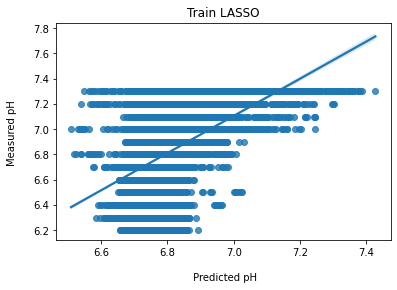

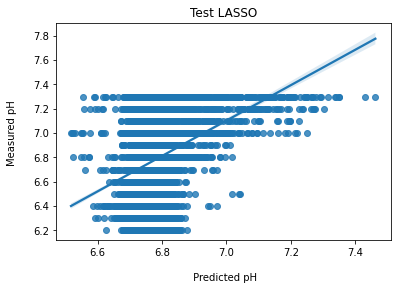

In [6]:
%%time

X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_lr, _, _ = train_lasso(X,Y)

### -- All spectra

(20000, 81)
------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.58 % 
 test  = 3.62 %
CPU times: user 9.59 s, sys: 4.49 s, total: 14.1 s
Wall time: 5.09 s


(Pipeline(steps=[('Scaler', StandardScaler()),
                 ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))]),
 3.58,
 3.62)

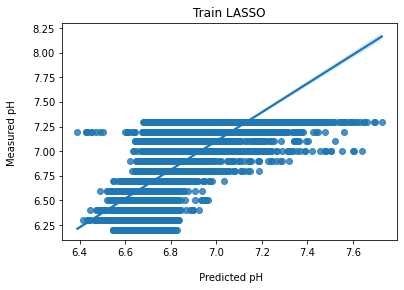

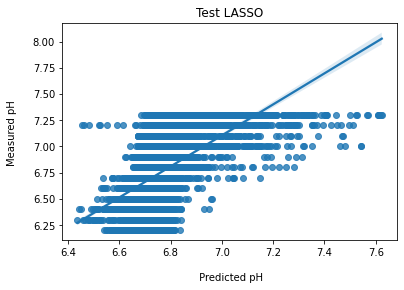

In [7]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 
print(Xdata.shape)
train_lasso(Xdata,Ydata)

### -- All data

(20000, 87)
------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.56 % 
 test  = 3.61 %
CPU times: user 10 s, sys: 4.09 s, total: 14.1 s
Wall time: 5.71 s


Lasso(alpha=0.01, max_iter=5000, random_state=42)

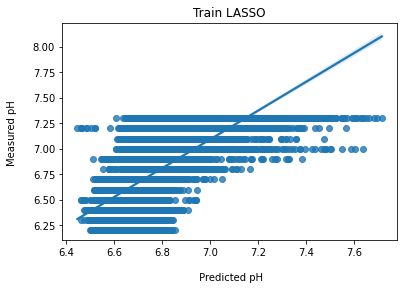

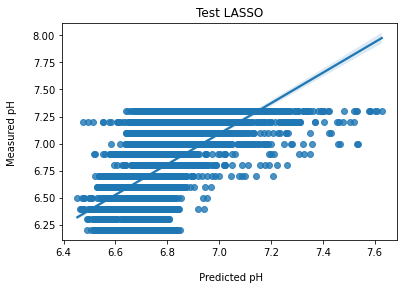

In [8]:
%%time

Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH
print(Xdata.shape)
lasso_all_data, _, _  = train_lasso(Xdata,Ydata)

lasso_all_data['lasso']

### -- selected features

#### | - all selected

CPU times: user 43.9 ms, sys: 4.56 ms, total: 48.5 ms
Wall time: 51.3 ms


Text(0, 0.5, 'Value \n')

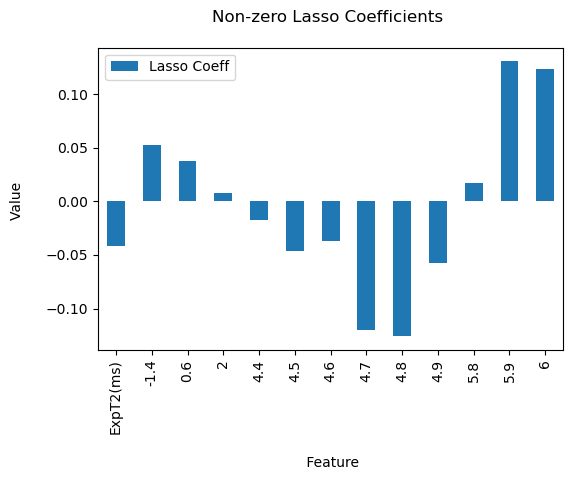

In [9]:
%%time

reg_lasso = lasso_all_data['lasso']

C = pd.DataFrame( reg_lasso.coef_ , columns=['Lasso Coeff'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100)

C[reg_lasso.coef_ != 0].plot(kind='bar', ax = ax)
plt.title('Non-zero Lasso Coefficients \n')
plt.xlabel('\n Feature')
plt.ylabel('Value \n')

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.56 % 
 test  = 3.61 %
CPU times: user 7.3 s, sys: 1.88 s, total: 9.18 s
Wall time: 1.91 s


Lasso(alpha=0.01, max_iter=5000, random_state=42)

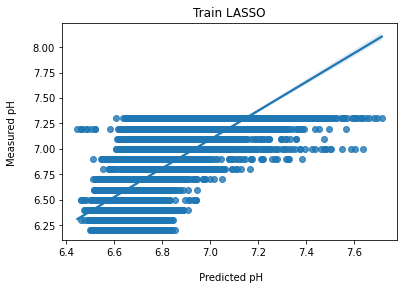

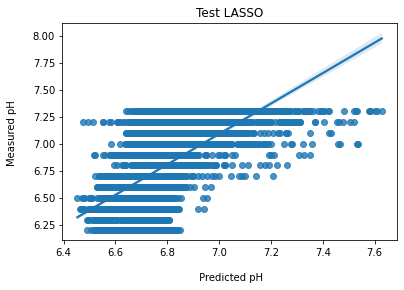

In [10]:
%%time

selected_cols_lasso = list(C[reg_lasso.coef_ != 0].index) # all data are non zero

Xdata = acidoCEST_ML[selected_cols_lasso]
Ydata = acidoCEST_ML.pH

lasso_selected, _, _ = train_lasso(Xdata[selected_cols_lasso],Ydata)

lasso_selected['lasso']

In [11]:
print(selected_cols_lasso)

['ExpT2(ms)', '-1.4', '0.6', '2', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5.8', '5.9', '6']


#### | - sat power vs  sat time

CPU times: user 3.43 s, sys: 234 ms, total: 3.67 s
Wall time: 4.22 s


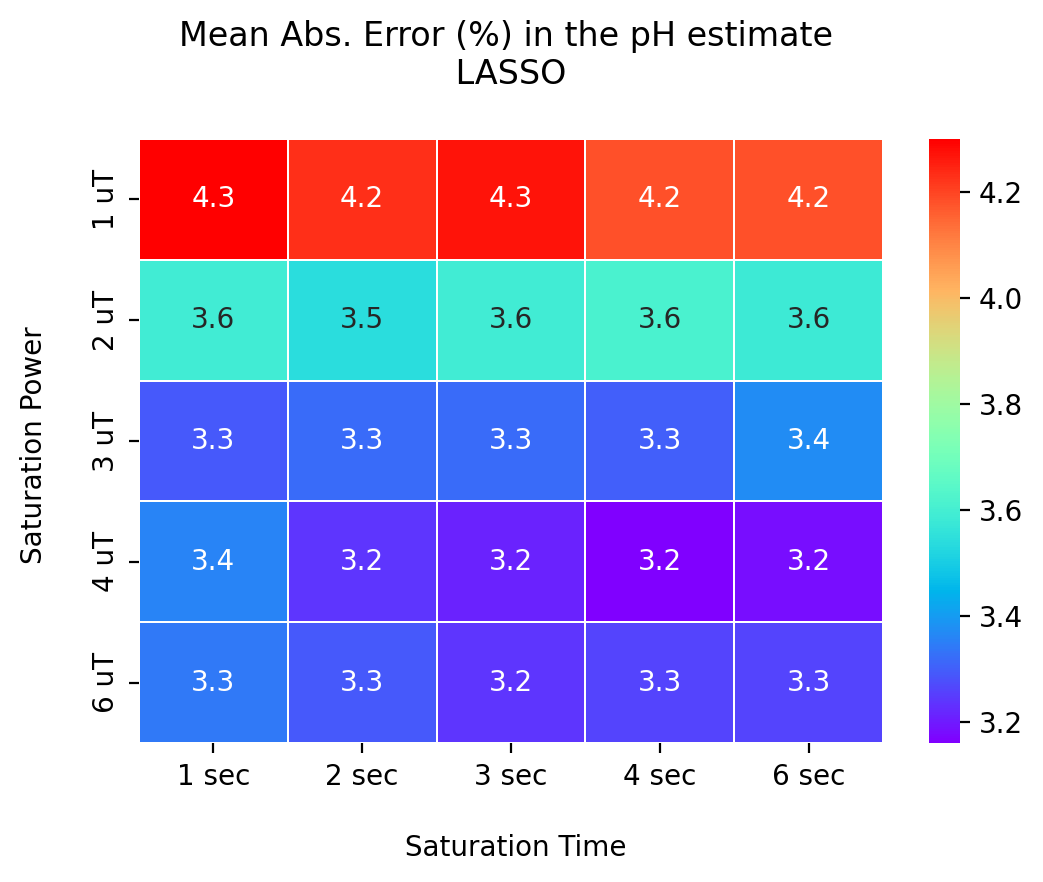

In [12]:
%%time

sat_times = acidoCEST_ML['SatTime(ms)'].unique()
#sat_times.sort()

sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
#sat_powers.sort()

M_lasso = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)

for t in sat_times:
    for p in sat_powers:
        D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]

        Xdata = D[selected_cols_lasso]
        Ydata = D['pH']
        
        lasso_selected, train, test = train_lasso(Xdata,Ydata, create_fig=0)
        M_lasso.loc[p,:][t] = test

M_lasso.columns = [str(int(x/1000)) + ' sec'  for x in M_lasso.columns]
M_lasso.index   = [f'{int(x)} uT' for  x in M_lasso.index ]

_, ax = plt.subplots(dpi=200)

cols_ = list(M_lasso.columns)
cols_.sort()

idx = list(M_lasso.index)
idx.sort()


sns.heatmap(M_lasso.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
plt.xlabel('\n Saturation Time')
plt.ylabel('Saturation Power \n')
plt.title('Mean Abs. Error (%) in the pH estimate \n LASSO \n')

plt.savefig(f'../figs/MATRIX_regression_LASSO.png',bbox_inches='tight')

## Random Forest

### -- 4.2 and 5.6

Fitting 3 folds for each of 12 candidates, totalling 36 fits
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 3.33 % 
 test  = 3.64 %
RandomForestRegressor(criterion='mae', max_depth=10, n_estimators=200,
                      n_jobs=-1, random_state=42)
CPU times: user 15min 23s, sys: 16.8 s, total: 15min 39s
Wall time: 23min 33s


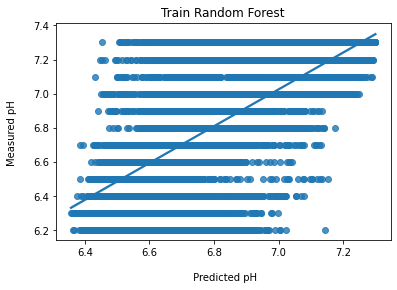

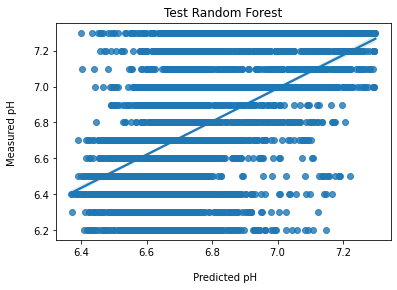

In [13]:
%%time

X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_rf, _, _ = train_RFR(X,Y,verbose=1)

### -- All sat frqeqs

In [ ]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 
print(Xdata.shape)
train_RFR(Xdata,Ydata,verbose=1)

(20000, 81)
Fitting 3 folds for each of 12 candidates, totalling 36 fits


### --  All data

In [ ]:
%%time

Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

RF_all_data, _, _    = train_RFR(Xdata,Ydata,verbose=1)

## Selected Features (top N)

#### | -  all selected

In [ ]:
I = pd.DataFrame( 100 * RF_all_data.feature_importances_, columns=['Importance'], index = Xdata.columns)
I = I.sort_values('Importance',ascending=False).head(20)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))

I.plot(kind='bar', ax = ax, rot=90)

In [ ]:
%%time

selected_cols_RF = list(I.index)
print(selected_cols_RF)

Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

RF_seleced_data, _, _    = train_RFR(Xdata[selected_cols_RF],Ydata, verbose=1)

#### | - sat power vs  sat time

In [ ]:
%%time

sat_times = acidoCEST_ML['SatTime(ms)'].unique()
#sat_times.sort()

sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
#sat_powers.sort()

M_RF = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)

for t in sat_times:
    for p in sat_powers:
        
        D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]
        
        Xdata = D[selected_cols_RF]
        Ydata = D['pH']
        
        _, train, test = train_RFR(Xdata,Ydata, create_fig=0, verbose=0)
        M_RF.loc[p,:][t] = test

In [ ]:
M_RF.columns = [str(int(x/1000)) + ' sec'  for x in M_RF.columns]
M_RF.index   = [f'{int(x)} uT' for  x in M_RF.index ]

_, ax = plt.subplots(dpi=200)

cols_ = list(M_RF.columns)
cols_.sort()

idx = list(M_RF.index)
idx.sort()


sns.heatmap(M_RF.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
plt.xlabel('\n Saturation Time')
plt.ylabel('Saturation Power \n')
plt.title('Mean Abs. Error (%) in the pH estimate \n LASSO \n')

plt.savefig(f'../figs/MATRIX_regression_RF.png',bbox_inches='tight')

## Tree Vis

In [ ]:
n_features = []

for i,tree in enumerate( RF_seleced_data.estimators_):
    ft = list( Xdata.columns[ tree.feature_importances_ != 0  ]  )
    n = len(Xdata.columns[ tree.feature_importances_ != 0  ])
    n_non_CEST = sum(['(' in x for x in ft])
    print(f' tree = {i+1} | {n - n_non_CEST} saturation frequencies | {n_non_CEST} non-CEST | total = {n}')
    n_features.append(n)

In [ ]:
%%capture
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


idx = np.argmin(n_features)-1
tree= RF_seleced_data.estimators_[idx]

#classes = list( pd.Series(tree.classes_).replace([0,1],[' pH < 7', 'pH > 7']).values )

fig = plt.figure(dpi=500)
plot_tree( tree,  feature_names = Xdata.columns,
          filled=True, impurity=False,  max_depth = 4, fontsize = 4, label='none', proportion =True,
          rounded=False);

plt.savefig(f'../figs/Tree_example_max_depth_04_tree{idx}_regression.png',bbox_inches='tight')

In [ ]:
from sklearn.tree import export_text

tree_as_text = export_text( tree
                  ,  max_depth = 4
                  ,  decimals = 3
                  ,  spacing = 3
                  , feature_names = list( Xdata.columns  )
                  , show_weights=True )   

## -- Selected features (without B1)

In [ ]:
%%time

cols_ = [x for x in selected_cols_RF if 'B1' not in x]


Xdata = acidoCEST_ML.drop( ['pH'],axis=1)[cols_]
Ydata = acidoCEST_ML.pH

RF_seleced_data_NoB1, _, _    = train_RFR(Xdata,Ydata, verbose=1)

## Compare Reg (all data)

In [ ]:
compare_reg = pd.DataFrame()
compare_reg['pH_measured'] = acidoCEST_ML.pH.values
compare_reg['pH_pred_LASSO'] = lasso_selected.predict(acidoCEST_ML.drop( ['pH'],axis=1)[selected_cols_lasso])
compare_reg['pH_pred_RF'] = RF_seleced_data.predict( acidoCEST_ML.drop( ['pH'],axis=1)[selected_cols_RF] )

_, ax = plt.subplots(dpi=100, figsize=(12,4), ncols=2 )

sns.regplot(x='pH_pred_RF'     , y='pH_measured', data = compare_reg, ax=ax[0], marker='s', x_bins=10)
sns.regplot(x='pH_pred_LASSO'  , y='pH_measured', data = compare_reg, ax=ax[1])


ll=6.1
ul=7.4

ax[0].set_ylim([ll, ul])
ax[1].set_ylim([ll, ul])

ax[0].set_xlim([ll, ul])
ax[1].set_xlim([ll, ul])

compare_reg.to_csv('../clean_data/compare_regs_sel_featurs.csv', index=False)